# Assignment 4 - Nicholas Thornton
### Do three of four.
### Please grade exercises 1, 2 and 3.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [16]:
df = pd.read_csv("data/mn_police_use_of_force.csv")

def bootstrap_missing(df, group_col, target_col, S=1000):
    results = []
    for race, group in df.groupby(group_col):
        estimates = []
        for _ in range(S):
            sample = group.sample(frac=1, replace=True)
            prop_missing = sample[target_col].isna().mean()
            estimates.append(prop_missing)
        results.append(pd.DataFrame({
            "race": race,
            "prop_missing": estimates
        }))
    return pd.concat(results, ignore_index=True)

boot_results = bootstrap_missing(df, "race", "subject_injury")

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_10696/1768948322.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=boot_results, x="prop_missing", hue="race", fill=True)


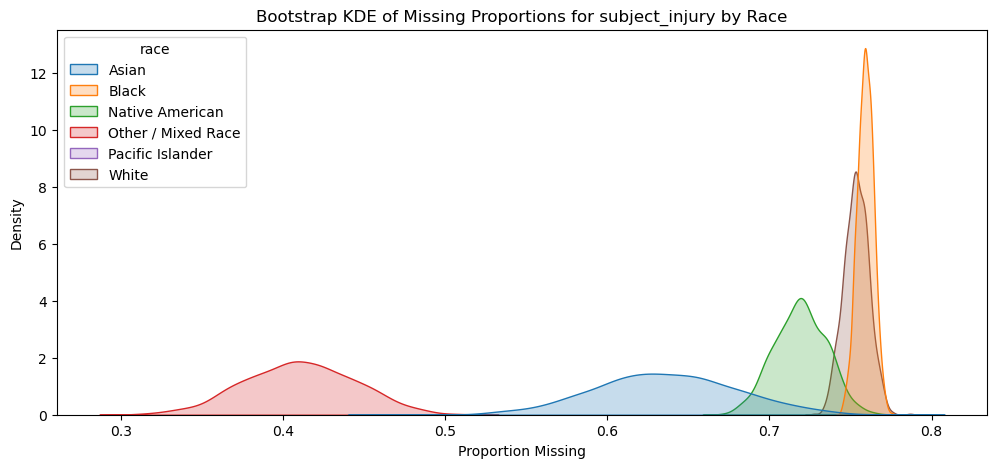

In [17]:
plt.figure(figsize=(12, 5))
sns.kdeplot(data=boot_results, x="prop_missing", hue="race", fill=True)
plt.title("Bootstrap KDE of Missing Proportions for subject_injury by Race")
plt.xlabel("Proportion Missing")
plt.show()

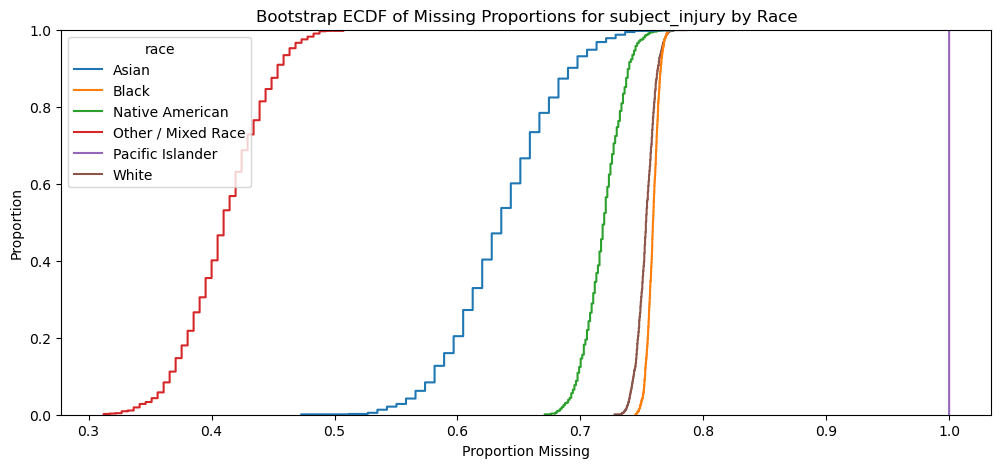

In [18]:
plt.figure(figsize=(12, 5))
sns.ecdfplot(data=boot_results, x="prop_missing", hue="race")
plt.title("Bootstrap ECDF of Missing Proportions for subject_injury by Race")
plt.xlabel("Proportion Missing")
plt.show()

The bootstrap results show clear differences in missing proportions of `subject_injury` across racial groups. White, Black, and Native American cases cluster tightly around high missingness (≈0.7–0.8), while Asian and Mixed Race cases have lower and more variable proportions (≈0.4–0.6). Pacific Islander appears as an extreme outlier with nearly all values missing. When considering second-order uncertainty, the distributions are distinct with little overlap, suggesting that patterns of missingness differ meaningfully by race and are not due to random sampling noise.

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data. Pick a variable and a statistic to compute (e.g. mean, median, variance, IQR)
- Use the `simulate` function from class to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

In [21]:
df = pd.read_csv("data/college_completion.csv")

def simulate_statistic(df, column, fcn, S=1000):
    estimates = []
    for _ in range(S):
        sample = df[column].dropna().sample(frac=1, replace=True)
        estimates.append(fcn(sample))
    return np.array(estimates)

def interval(L, H, estimates):
    return np.quantile(estimates, [L, H])

estimates = simulate_statistic(df, "grad_100_value", np.mean)
ci = interval(0.05, 0.95, estimates)

print("90% Confidence Interval:", ci)

90% Confidence Interval: [27.75089991 29.00623882]


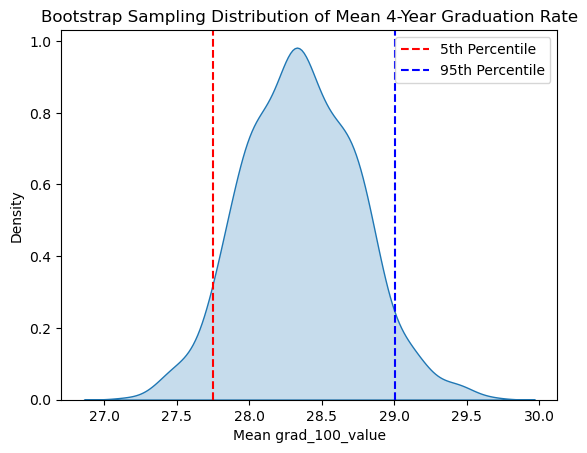

In [22]:
sns.kdeplot(estimates, fill=True)
plt.axvline(ci[0], color="red", linestyle="--", label="5th Percentile")
plt.axvline(ci[1], color="blue", linestyle="--", label="95th Percentile")
plt.title("Bootstrap Sampling Distribution of Mean 4-Year Graduation Rate")
plt.xlabel("Mean grad_100_value")
plt.legend()
plt.show()

The bootstrap sampling distribution of the mean 4-year graduation rate (`grad_100_value`) is centered around 28–29 percent. The 90% confidence interval [27.75, 29.01] indicates that if we repeated this sampling process many times, 90% of the intervals would contain the true population mean graduation rate. The distribution is unimodal and fairly symmetric, suggesting that the sample provides a stable estimate of the mean. This supports the use of bootstrap confidence intervals as a reliable method for inference without requiring normality assumptions.


### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

Goal of the Trial: The purpose of the ISCHEMIA-CKD trial is to determine the best management strategy for patients with stable ischemic heart disease 
Plan: They have an invasive strategy where the patients get "cardiac catheterization followed by revascularization (Percutaneous Coronary Intervention or Coronary Artery Bypass Graft Surgery) plus optimal medical therapy." or a conservative strategy where the patients get "Optimal medical therapy with cardiac catheterization and revascularization reserved for patients with OMT failure." Patients were randomly assigned to the interventions 

The invasive strategy has a death rate of 31.7% while the conservative strategy has a rate of 33.2%

In [9]:
data = {
    "strategy": ["Invasive", "Conservative"],
    "population": [388, 389],
    "prop_death": [0.317, 0.332]
}

df_info = pd.DataFrame(data)


rows = []
for _, row in df_info.iterrows():
    n = row["population"]
    n_deaths = int(round(n * row["prop_death"]))
    n_survive = n - n_deaths
    
   
    outcomes = np.array([1]*n_deaths + [0]*n_survive)
    np.random.shuffle(outcomes) 
    
    
    group_df = pd.DataFrame({
        "strategy": row["strategy"],
        "outcome": outcomes
    })
    
    rows.append(group_df)

df = pd.concat(rows, ignore_index=True)
df.head()

,strategy,outcome
0,Invasive,0
1,Invasive,0
2,Invasive,0
3,Invasive,0
4,Invasive,1


In [10]:
def simulate_mean(df, strategy, S=1000):
    x = df.loc[df["strategy"] == strategy, "outcome"]
    estimates = []
    for s in range(S):
        x_s = x.sample(frac=1.0, replace=True)
        estimates.append(x_s.mean())
    return np.array(estimates)


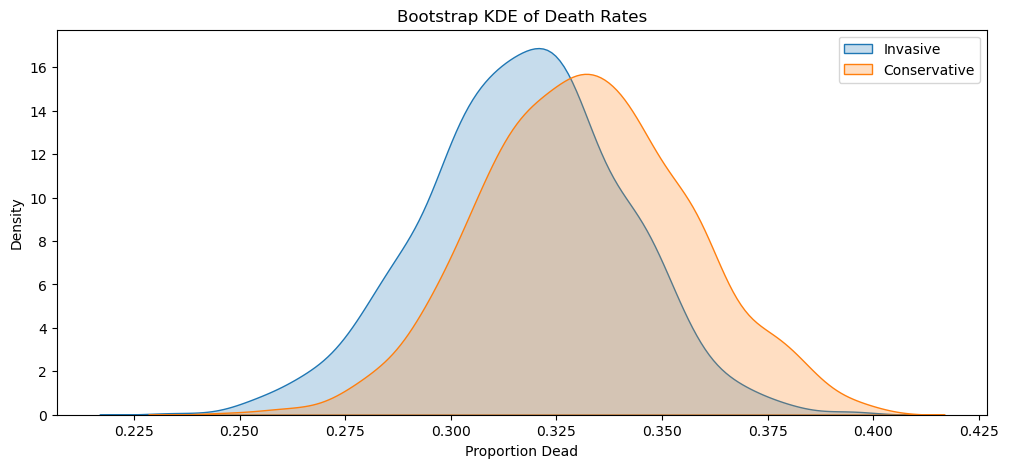

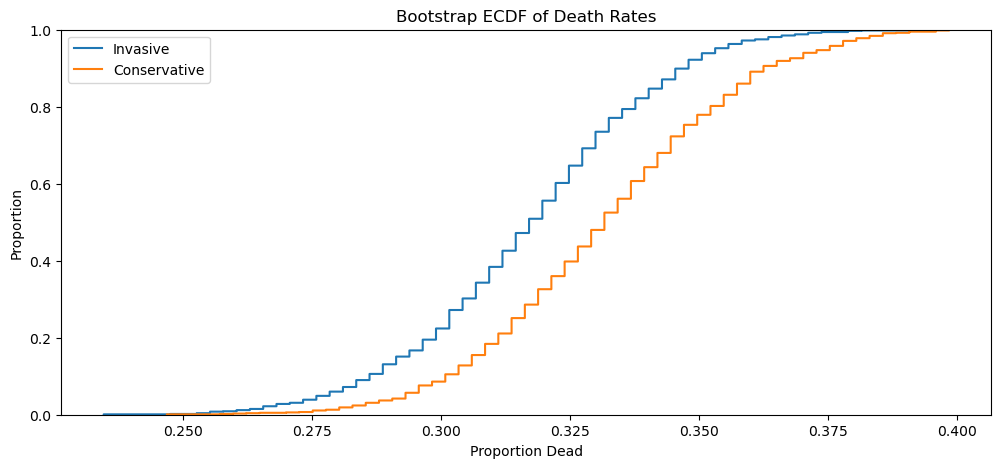

In [11]:
invasive_est = simulate_mean(df, "Invasive")
conservative_est = simulate_mean(df, "Conservative")

plt.figure(figsize=(12,5))
sns.kdeplot(invasive_est, label="Invasive", fill=True)
sns.kdeplot(conservative_est, label="Conservative", fill=True)
plt.title("Bootstrap KDE of Death Rates")
plt.xlabel("Proportion Dead")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
sns.ecdfplot(invasive_est, label="Invasive")
sns.ecdfplot(conservative_est, label="Conservative")
plt.title("Bootstrap ECDF of Death Rates")
plt.xlabel("Proportion Dead")
plt.legend()
plt.show()

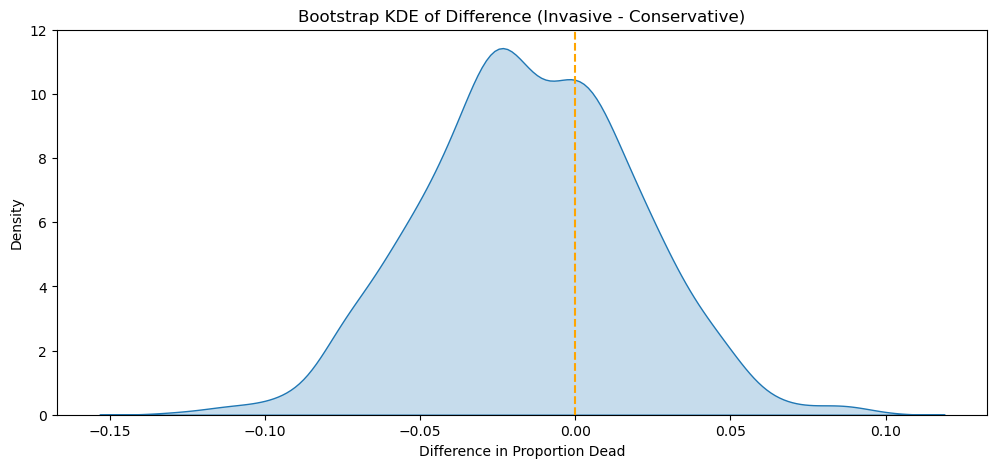

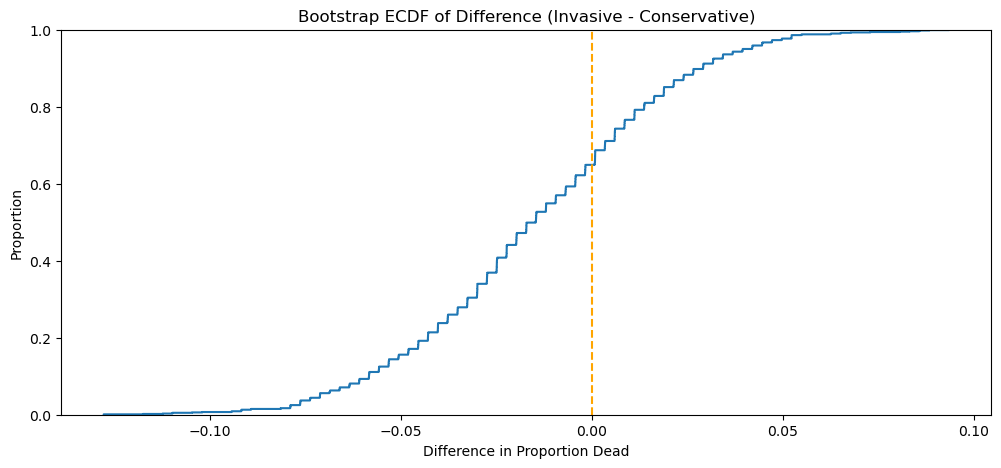

In [12]:
diff_est = invasive_est - conservative_est

plt.figure(figsize=(12,5))
sns.kdeplot(diff_est, fill=True)
plt.axvline(0, color="orange", linestyle="--")
plt.title("Bootstrap KDE of Difference (Invasive - Conservative)")
plt.xlabel("Difference in Proportion Dead")
plt.show()

plt.figure(figsize=(12,5))
sns.ecdfplot(diff_est)
plt.axvline(0, color="orange", linestyle="--")
plt.title("Bootstrap ECDF of Difference (Invasive - Conservative)")
plt.xlabel("Difference in Proportion Dead")
plt.show()


### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

In [2]:
iowa = pd.read_csv("./data/iowa.csv")
xy = (
    iowa.loc[:, ["Bottles Sold", "Sale (Dollars)"]]
        .rename(columns={"Bottles Sold": "x", "Sale (Dollars)": "y"})
        .dropna()
        .astype({"x": float, "y": float})
)
x = xy["x"].to_numpy()
y = xy["y"].to_numpy()

In [3]:
# Silverman's bandwidth (plugin estimator)
def silverman_bandwidth(x):
    n = len(x)
    std = np.std(x, ddof=1)
    return 1.06 * std * n ** (-1/5)

# Epanechnikov kernel
def epanechnikov(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

# Nadaraya-Watson / LCLS estimator with Epanechnikov kernel
def nadaraya_watson(x_train, y_train, x_eval, h=None):
    if h is None:
        h = silverman_bandwidth(x_train)
    estimates = []
    for z in x_eval:
        weights = epanechnikov((z - x_train) / h)
        if weights.sum() > 0:
            y_hat = np.sum(weights * y_train) / np.sum(weights)
        else:
            y_hat = np.nan
        estimates.append(y_hat)
    return np.array(estimates)

x_eval = np.linspace(np.percentile(x, 1), np.percentile(x, 99), 200)

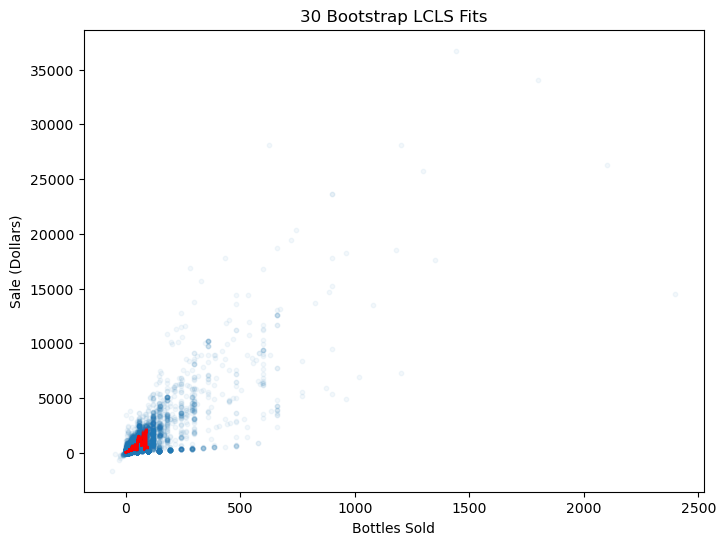

In [4]:
# 1. Bootstrap 30 samples, plot variation in lines

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.05, s=10, label="Raw Data")

for b in range(30):
    idx = np.random.choice(len(x), size=len(x), replace=True)
    x_boot, y_boot = x[idx], y[idx]
    y_hat = nadaraya_watson(x_boot, y_boot, x_eval)
    plt.plot(x_eval, y_hat, color="red", alpha=0.3)

plt.title("30 Bootstrap LCLS Fits")
plt.xlabel("Bottles Sold")
plt.ylabel("Sale (Dollars)")
plt.show()

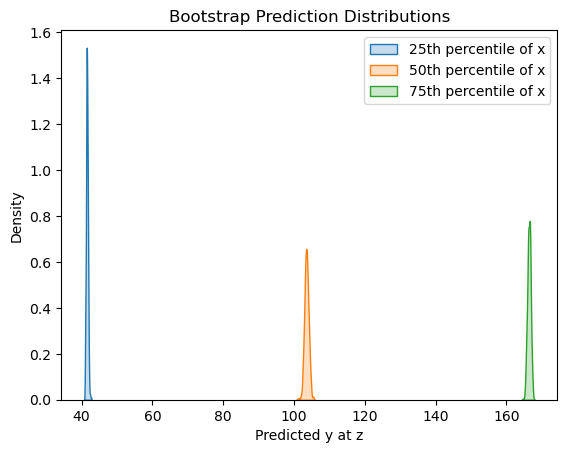

In [5]:
# 2. Distribution of predictions at specific percentiles

for q in [25, 50, 75]:
    z = np.percentile(x, q)
    preds = []
    for b in range(500):  
        idx = np.random.choice(len(x), size=len(x), replace=True)
        x_boot, y_boot = x[idx], y[idx]
        y_hat = nadaraya_watson(x_boot, y_boot, [z])[0]
        preds.append(y_hat)
    
    sns.kdeplot(preds, fill=True, label=f"{q}th percentile of x")
    
plt.title("Bootstrap Prediction Distributions")
plt.xlabel("Predicted y at z")
plt.legend()
plt.show()

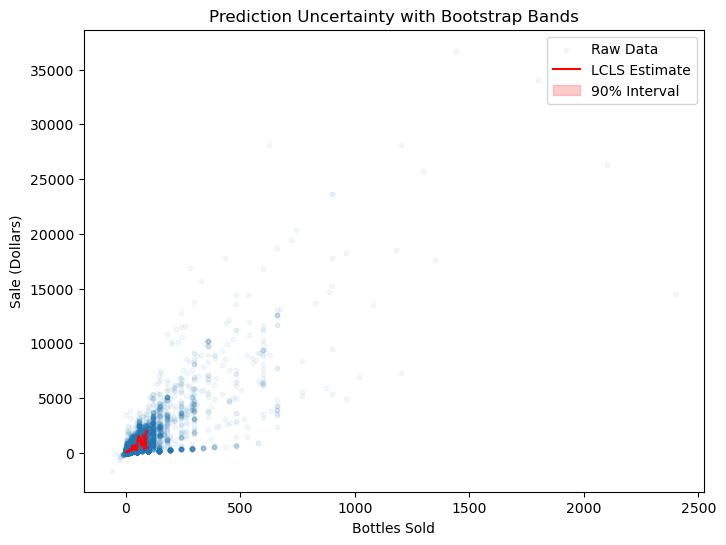

In [6]:
# 3. Error bands (.05 and .95 quantiles) across grid

all_preds = []
B = 200  # number of bootstraps
for b in range(B):
    idx = np.random.choice(len(x), size=len(x), replace=True)
    x_boot, y_boot = x[idx], y[idx]
    y_hat = nadaraya_watson(x_boot, y_boot, x_eval)
    all_preds.append(y_hat)

all_preds = np.array(all_preds)  

y_hat_main = nadaraya_watson(x, y, x_eval)
lower = np.percentile(all_preds, 5, axis=0)
upper = np.percentile(all_preds, 95, axis=0)

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.05, s=10, label="Raw Data")
plt.plot(x_eval, y_hat_main, color="red", label="LCLS Estimate")
plt.fill_between(x_eval, lower, upper, color="red", alpha=0.2, label="90% Interval")
plt.title("Prediction Uncertainty with Bootstrap Bands")
plt.xlabel("Bottles Sold")
plt.ylabel("Sale (Dollars)")
plt.legend()
plt.show()

Bootstrapped fits show that predictions are tight and reliable at low-to-moderate sales volumes where data are dense, as reflected by narrow confidence bands and stable KDE distributions at the 25th, 50th, and 75th percentiles. However, uncertainty grows at higher volumes where data are sparse, leading to wider intervals and greater variability in the bootstrap fits, making predictions in this range less reliable.
